# CausalRCA

The original implementation is here. <https://github.com/AXinx/CausalRCA_code/>

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 7
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', FutureWarning)

import sys
sys.path.append("../")

import logging
logger = logging.getLogger()
if not logger.handlers:
    handler = logging.StreamHandler(sys.stdout)
    handler.setLevel(logging.INFO)
    logger.addHandler(handler)
    logger.setLevel(logging.INFO)

In [3]:
SOCKSHOP_DATASET_ID = "9n6mf"
TRAINTICKET_DATASET_ID = "m9dgg"

from meltria.priorknowledge.priorknowledge import SockShopKnowledge

sockshop_pk = SockShopKnowledge(
    target_metric_types={
        "containers": True,
        "services": True,
        "middlewares": True,
        "nodes": False,
    },
    mappings={"nodes-containers": {}},
)

In [4]:
from eval.tsdr import load_tsdr_by_chaos

dataset_by_chaos = load_tsdr_by_chaos(
    SOCKSHOP_DATASET_ID, {
        "services": True,
        "containers": True,
        "middlewares": False,
        "nodes": False,
    },
    revert_normalized_time_series=True,
    tsdr_options={
        "enable_unireducer": True,
        "enable_multireducer": True,
        "step1_method_name": "residual_integral",
        "step1_residual_integral_threshold": 20,
        "step1_residual_integral_change_start_point": False,
        "step1_residual_integral_change_start_point_n_sigma": 3,
        "step2_dbscan_min_pts": 1,
        "step2_dbscan_dist_type": "pearsonr",  # 'pearsonr' or 'sbd'
        "step2_dbscan_algorithm": "dbscan",  # 'dbscan' or 'hdbscan'
        "step2_clustering_series_type": "raw",  # 'raw', 'anomaly_score' or 'binary_anomaly_score'
        "step2_clustering_choice_method": "medoid",  # 'medoid' or 'maxsum'
    },
    use_manually_selected_metrics=False,
) 

In [65]:
record, data_df_by_metric_type = dataset_by_chaos[("pod-network-latency", "carts")][0]
dataset = pd.concat([
    data_df_by_metric_type["containers"][-1].iloc[0:180,:],
    data_df_by_metric_type["services"][-1].iloc[0:180, :],
], axis=1)
dataset.shape

(180, 72)

In [66]:
MANUALLY_SELECTED_METRICS: set[str] = {
    "latency",
    "cpu_usage_seconds_total",
    "memory_working_set_bytes",
    "fs_reads_total",
    "fs_writes_total",
    "network_receive_bytes_total",
    "network_transmit_bytes_total",
}

container_names = ['front-end', 'user', 'catalogue', 'orders', 'carts', 'payment', 'shipping']

def filter_manually_selected_metrics(df: pd.DataFrame) -> pd.DataFrame:
    # Filter only container metrics
    return df.loc[
        :,
        [
            (not metric_name.startswith("m-") and not metric_name.startswith("n-")) and any([metric_name.endswith(base_name) for base_name in MANUALLY_SELECTED_METRICS])
            for metric_name in df.columns.tolist()
        ],
    ]

def filter_by_container_names(df: pd.DataFrame) -> pd.DataFrame:
    return df.loc[
        :,
        [
            metric_name.split("_")[0].removeprefix("c-") in container_names
            for metric_name in df.columns.tolist()
        ],
    ]

dataset = filter_by_container_names(filter_manually_selected_metrics(record.data_df).iloc[0:180, :])
dataset.shape

(180, 42)

In [7]:
from diagnoser.causalrca import CausalRCA
from diagnoser.daggnn.config import Config

In [73]:
import torch

torch.set_num_threads(1)

params = Config().to_prefixed_dict(prefix="causalrca")
conf = Config.from_prefixed_dict(prefix="causalrca", **params)
print(conf)
causalrca = CausalRCA(dataset, conf)
graph_adj, elapsed = causalrca.fit()

Config(epochs=1000, sample_to_batch_size_factor=5, lr=0.001, x_dims=1, z_dims=1, optimizer='Adam', graph_threshold=0.3, tau_A=0.0, lambda_A=0.0, c_A=1, c_A_ul=1e+20, use_A_connect_loss=1, use_A_positiver_loss=1, cuda=False, seed=42, encoder_hidden=64, decoder_hidden=64, temp=0.5, k_max_iter=5, encoder='mlp', decoder='mlp', encoder_dropout=0.0, decoder_dropout=0.0, h_tol=1e-08, lr_decay=200, sche_gamma=1.0, prior=False, factor=True, eta=10, gamma=0.25)
Step: 1/5, Best Epoch: 998/1000, ELBO Loss: 182300765342.66504, NLL Loss: 896.8928846303996, MSE Loss: 42.70918498239998
Step: 2/5, Best Epoch: 947/1000, ELBO Loss: 125002404864.11018, NLL Loss: 896.8928846303996, MSE Loss: 42.70918498239998
Done!


In [74]:
ranks = causalrca.rank(graph_adj)
ranks

{15: ('c-front-end_network_receive_bytes_total', 0.02795048143328798),
 27: ('c-shipping_network_receive_bytes_total', 0.027353396699374838),
 33: ('c-payment_network_receive_bytes_total', 0.027311861009104488),
 39: ('c-user_network_receive_bytes_total', 0.026534903919365166),
 41: ('c-user_network_transmit_bytes_total', 0.02653309971716717),
 9: ('c-catalogue_network_receive_bytes_total', 0.026516088636447943),
 11: ('c-catalogue_network_transmit_bytes_total', 0.026515637708873774),
 23: ('c-orders_network_transmit_bytes_total', 0.026484769531896372),
 21: ('c-orders_network_receive_bytes_total', 0.02647842911839722),
 40: ('c-user_fs_reads_total', 0.02637637060126128),
 36: ('c-user_fs_writes_total', 0.026376367499998426),
 28: ('c-shipping_fs_reads_total', 0.026376363226643273),
 16: ('c-front-end_fs_reads_total', 0.026376349061405128),
 0: ('c-carts_fs_writes_total', 0.026376343651540037),
 18: ('c-orders_fs_writes_total', 0.026376341989803865),
 12: ('c-front-end_fs_writes_total'

[]

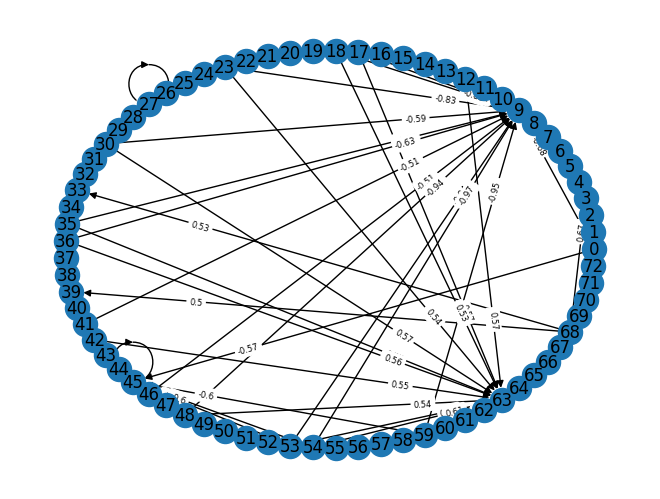

In [52]:
import networkx as nx

_graph_adj = graph_adj.copy()
_graph_adj[np.abs(_graph_adj) < 0.5] = 0
org_G = nx.DiGraph(_graph_adj)
pos=nx.circular_layout(org_G)
nx.draw(org_G, pos=pos, with_labels=True)
edge_labels = {k: round(w, 2) for k, w in nx.get_edge_attributes(org_G, "weight").items()}
nx.draw_networkx_edge_labels(org_G, pos, edge_labels=edge_labels, font_size=6, label_pos=0.25)
plt.plot()

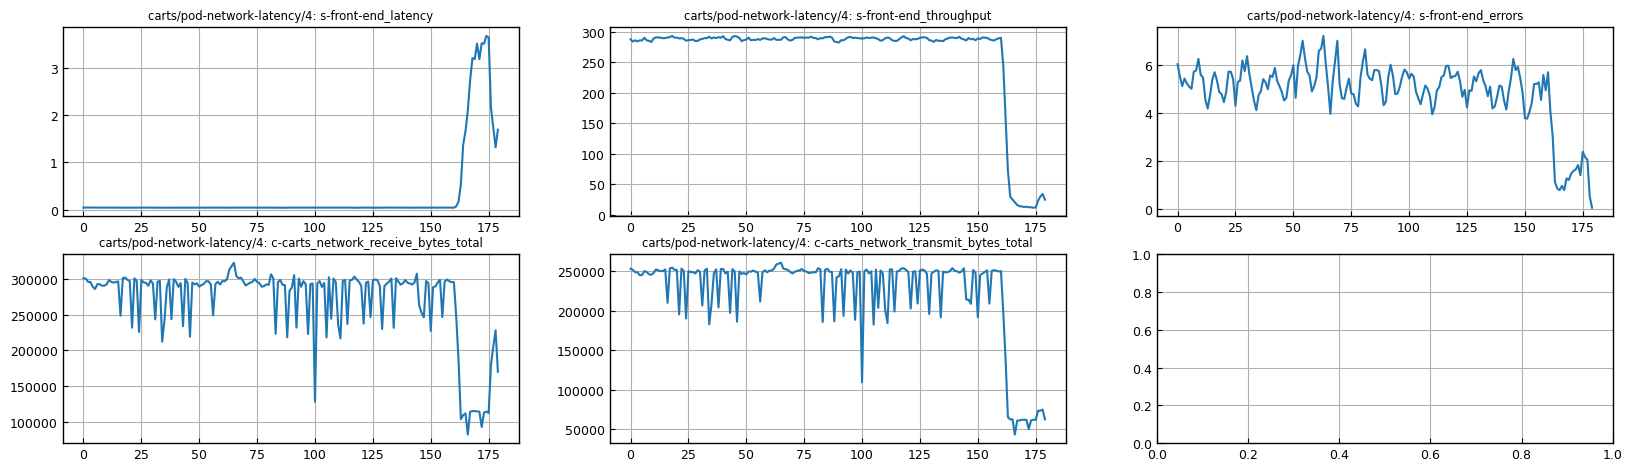

In [69]:
from notebooklib import plot

plot.plot_sli_and_causal_metrics(dataset, record)
# plot.plot_dataset_dataframe(dataset, record)